In [1]:
from PyPDF2 import PdfReader
import numpy as np
import pandas as pd
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tabulate import tabulate
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# To start 

# extract list of words related to social, environment and economy sustainability and merge them in a unique list 
social = pd.read_excel('social.xlsx')
environment = pd.read_excel('environment.xlsx')
economy = pd.read_excel('economy.xlsx')
social_words = social['social words'].tolist()
environment_words = environment['environment words'].tolist()
economy_words = economy['economy words'].tolist()
words_list = social_words + environment_words + economy_words

# get the set of stop words
stop_words = set(stopwords.words("english"))

cleaner = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

# extract negative and positive words from the Loughran-McDonald list 
LM_dictionary = pd.read_excel('LM_MasterDictionary.xlsx', dtype={'Word': str})
neg = LM_dictionary[LM_dictionary['Negative']>0]['Word'].tolist()
pos = LM_dictionary[LM_dictionary['Positive']>0]['Word'].tolist()

analyzer = SentimentIntensityAnalyzer()

lemmatizer = WordNetLemmatizer()

words = set(nltk.corpus.words.words())

In [3]:
# Functions

# extract a pdf_file 
def extract(pdf_file:str):
    file_read = PdfReader(pdf_file)
    pdf_text=""
    for page in file_read.pages:
        content = page.extract_text()
        pdf_text += content
    return pdf_text 

# remove links from a string 
def cleanhtml(raw_html):
  cleantext = re.sub(cleaner, '', raw_html)
  return cleantext

# remove numbers from a string 
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

# remove punctuation from a string 
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# remove additional white spaces from a string  
def remove_whitespace(text):
    return  " ".join(text.split())

# selection of ESG-related sentences from the cleaned report (function to go from the report to the ESG-related report) 
def clean_list(list,list_of_words):
    new_list = []
    accepted = 0 
    total_number_phrases = len(list)
    for phrase in list:
        phrase = remove_punctuation(phrase) # remove punctuation
        phrase = re.sub(r'[^\w]', ' ', phrase) # remove all character that are different from words
        words_list = word_tokenize(phrase) # create a list of words from the string phrase
        filtered_words_list = [word for word in words_list if word not in stop_words] # remove stopwords
        count = 0
        n = len(filtered_words_list)
        for i in range(0,n):
            for word in list_of_words:
                if filtered_words_list[i]==word.lower(): 
                    count += 1 
                elif i<n-1 and filtered_words_list[i]+" "+filtered_words_list[i+1]==word.lower(): 
                    count += 1 
                elif i<n-2 and filtered_words_list[i]+" "+filtered_words_list[i+1]+" "+filtered_words_list[i+2]==word.lower():
                    count += 1 
                elif i<n-3 and filtered_words_list[i]+" "+filtered_words_list[i+1]+" "+filtered_words_list[i+2]+" "+filtered_words_list[i+3]==word.lower():
                    count += 1
                elif i<n-4 and filtered_words_list[i]+" "+filtered_words_list[i+1]+" "+filtered_words_list[i+2]+" "+filtered_words_list[i+3]+" "+filtered_words_list[i+4]==word.lower():
                    count += 1
        if count != 0: 
            accepted += 1
            phrase = ' '.join(filtered_words_list)  
            new_list = new_list + [phrase]
    return new_list, accepted/total_number_phrases

# compute polarity of a string using the Loughran-McDonalds list 
def count_neg_pos(text):
    count_pos = 0
    count_neg = 0
    list_neg = []
    list_pos = []
    for word in word_tokenize(text):
        if word.upper() in neg:
            count_neg += 1 
            list_neg = list_neg + [word] 
        if word.upper() in pos:
            count_pos += 1 
            list_pos = list_pos + [word] 
    return (count_pos-count_neg)/(count_pos+count_neg), list_neg, list_pos

# applies vader algorithm to each element of the list in input, take track of other statistics
def vader_phrase(list):
    n = len(list)
    count_pos = 0
    count_neg = 0 
    count_neut = 0 
    pos = 0 
    neg = 0 
    neut = 0
    compound = 0 
    for sentence in list:
        score = analyzer.polarity_scores(sentence)
        compound = score['compound'] + compound
        if score['compound']>= 0.05:
            count_pos += 1
            pos = pos + score['compound']
        elif score['compound']<= -0.05:
            count_neg += 1
            neg = neg + score['compound']
        else: 
            count_neut += 1
            neut = neut + score['compound']
    if n>0 : 
        x = count_pos/n
        y = count_neg/n
        z = count_neut/n
    else:
        x = 0
        y = 0 
        z = 0
    if count_pos>0: 
        a = pos/count_pos
    else: 
        a = 0 
    if count_neg>0:
        b = neg/count_neg
    else: 
        b = 0
    if count_neut>0:
        c = neut/count_neut
    else: 
        c = 0 
    array = np.array([compound/n,x, y, z, a, b, c])
    return array 

# applies vader algorithm to a string 
def vader_doc(text): 
    score = analyzer.polarity_scores(text)
    if score['compound']>= 0.05:
        result = 'positive'
    elif score['compound']<= -0.05:
        result = 'negative'
    else: 
        result = 'neutral'
    array = np.array([result, score['compound']])
    return array

# lemmatize a string 
def lemmatize_word(text):
    word_tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return lemmas

# create a list with the multiples of m 
def multiples(m, count):
    x = []
    for i in range(count):
        x = x + [i*m]
    return x

## VADER 

This following cell was used to collect information of the average compound score to then store them in an excel file.

In [4]:
# ESG sentiment analysis with VADER for the last report posted by companies (all for year 2022 except Royal Energy that is for year 2021) 
company_list_dir = os.getcwd() + '/10-KLast'
company_list_pdf = os.listdir(company_list_dir)
company_list_names = []
for company in company_list_pdf:
    company_list_names = company_list_names + [company[4:-8]] 
df_phrases = pd.DataFrame(columns=['average_compound','perc_pos','perc_neg','perc_neut', 'mean_pos', 'mean_neg', 'mean_neut', 'perc_esg_phrases'], index=company_list_names)
df_document = pd.DataFrame(columns=['sentiment','score'], index=company_list_names)
count = 0
for i in company_list_pdf: 
    x = extract(company_list_dir + f"/{i}")
    x = cleanhtml(x)
    x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)
    x = x.lower()
    x = remove_numbers(x)
    x = x.split(".")
    x,acceptance_rate = clean_list(x,words_list)
    series_phrases = vader_phrase(x)
    df_phrases.loc[company_list_names[count]] = pd.Series({'average_compound': series_phrases[0],'perc_pos': series_phrases[1], 'perc_neg': series_phrases[2], 'perc_neut': series_phrases[3], 'mean_pos': series_phrases[4], 'mean_neg': series_phrases[5], 'mean_neut': series_phrases[6], 'perc_esg_phrases': acceptance_rate})
    x = ' '.join(x)
    series_document = vader_doc(x)
    df_document.loc[company_list_names[count]] =  pd.Series({'sentiment': series_document[0], 'score': series_document[1]})
    count += 1

In [5]:
# vader sentence level average compound score and other statistics of 2022 reports 
# perc_pos/neg/neut = percentage of sentences classified as positive/negative/neutral in the ESG-related report
# mean_pos/neg/neut = average of compound score within sentences classified as positive/negative/neutral
# perc_esg_phrases = percentage of phrases selected from the cleaned report
df_phrases

,average_compound,perc_pos,perc_neg,perc_neut,mean_pos,mean_neg,mean_neut,perc_esg_phrases
BankOfAmerica,0.611464,0.857143,0.0,0.142857,0.713375,0.0,0.0,0.129032
BeyondMeat,0.217889,0.584582,0.229122,0.186296,0.572445,-0.508928,-0.000782,0.12574
Campbell,0.200025,0.532033,0.211699,0.256267,0.534457,-0.399124,0.000663,0.156427
Chevron,0.198622,0.526502,0.208481,0.265018,0.552858,-0.44349,0.0,0.094554
Citigroup,0.26617,0.593396,0.170755,0.235849,0.561024,-0.390506,-0.000252,0.094931
ConocoPhillips,0.21887,0.559557,0.191136,0.249307,0.5242,-0.390633,0.00086,0.09016
Ford,0.272317,0.601852,0.15,0.248148,0.553785,-0.407302,0.000469,0.110452
GeneralElectric,0.253466,0.60396,0.160396,0.235644,0.537342,-0.440842,-0.001518,0.163008
Hershey,0.380777,0.710106,0.106383,0.183511,0.608407,-0.48209,0.000162,0.126217
JPMorgan,0.282313,0.651561,0.21853,0.129909,0.601514,-0.502056,0.0008,0.094653


The worst among cars: Rivian
The best among cars: Tesla

The worst among banks: Citigroup
The best among banks: BankOfAmerica

The worst among energy: Petrogas
The best among energy: GeneralElectric

The worst among food: Champbell
The best among food: Hershey

According to Vader the best company is BankOfAmerica and the worst is Petrogas

In [9]:
# vader document level average compound score of 2022 reports 
df_document

,sentiment,score
BankOfAmerica,positive,0.9999
BeyondMeat,positive,1.0
Campbell,positive,1.0
Chevron,positive,0.9999
Citigroup,positive,1.0
ConocoPhillips,positive,1.0
Ford,positive,1.0
GeneralElectric,positive,1.0
Hershey,positive,1.0
JPMorgan,positive,1.0


In [15]:
# visualization of some statistics
# general mean and std 
mean_scores = df_phrases['average_compound'].mean()
std_scores = df_phrases['average_compound'].std()
# per industry mean and std 
mean_cars = df_phrases.loc[['Ford', 'Tesla', 'StandardMotor', 'Rivian', 'MotorcarParts']]['average_compound'].mean()
std_cars = df_phrases.loc[['Ford', 'Tesla', 'StandardMotor', 'Rivian', 'MotorcarParts']]['average_compound'].std()
mean_banks = df_phrases.loc[['MorganStanley', 'Silicon', 'JPMorgan', 'Citigroup', 'BankOfAmerica']]['average_compound'].mean()
std_banks =  df_phrases.loc[['MorganStanley', 'Silicon', 'JPMorgan', 'Citigroup', 'BankOfAmerica']]['average_compound'].std()
mean_energy = df_phrases.loc[['Chevron', 'ConocoPhillips', 'GeneralElectric', 'Petrogas', 'RoyalEnergy']]['average_compound'].mean()
std_energy = df_phrases.loc[['Chevron', 'ConocoPhillips', 'GeneralElectric', 'Petrogas', 'RoyalEnergy']]['average_compound'].std()
mean_food = df_phrases.loc[['BeyondMeat', 'Campbell', 'Hershey', 'Kellogg', 'McDonald']]['average_compound'].mean()
std_food = df_phrases.loc[['BeyondMeat', 'Campbell', 'Hershey', 'Kellogg', 'McDonald']]['average_compound'].std()


In [16]:
print(tabulate([['General_mean', mean_scores],['General_std',std_scores],
                ['Mean_cars',mean_cars], ['Std_cars',std_cars],['Mean_banks',mean_banks],
                ['Std_banks',std_banks], ['Mean_energy',mean_energy],['Std_energy',std_energy],
                ['Mean_food',mean_food],['Std_food',std_food]],
                headers=['Statistics', 'Values'],tablefmt = 'fancy_grid',stralign = 'center', numalign= 'center',floatfmt=".2f"))

╒══════════════╤══════════╕
│  Statistics  │  Values  │
╞══════════════╪══════════╡
│ General_mean │   0.26   │
├──────────────┼──────────┤
│ General_std  │   0.10   │
├──────────────┼──────────┤
│  Mean_cars   │   0.25   │
├──────────────┼──────────┤
│   Std_cars   │   0.03   │
├──────────────┼──────────┤
│  Mean_banks  │   0.33   │
├──────────────┼──────────┤
│  Std_banks   │   0.16   │
├──────────────┼──────────┤
│ Mean_energy  │   0.21   │
├──────────────┼──────────┤
│  Std_energy  │   0.07   │
├──────────────┼──────────┤
│  Mean_food   │   0.27   │
├──────────────┼──────────┤
│   Std_food   │   0.07   │
╘══════════════╧══════════╛


The industry with the smallest mean is energy

In [4]:
# ESG sentiment analysis with VADER for the last report posted by companies from 2019 to 2022 (except Royal Energy and Rivian) 
company_list_dir = os.getcwd() + '/10-K_time_2019-2022'
company_list_pdf = os.listdir(company_list_dir)
company_list_names = []
for company in company_list_pdf:
    company_list_names = company_list_names + [company[4:-4]] 
df_phrases_evolution = pd.DataFrame(columns=['average_compound','perc_pos','perc_neg','perc_neut', 'mean_pos', 'mean_neg', 'mean_neut', 'perc_esg_phrases'], index=company_list_names)
df_document_evolution = pd.DataFrame(columns=['sentiment','score'], index=company_list_names)
count = 0
for i in company_list_pdf: 
    x = extract(company_list_dir + f"/{i}")
    x = cleanhtml(x)
    x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)
    x = x.lower()
    x = remove_numbers(x)
    x = x.split(".")
    x,acceptance_rate = clean_list(x,words_list)
    series_phrases = vader_phrase(x)
    df_phrases_evolution.loc[company_list_names[count]] = pd.Series({'average_compound': series_phrases[0],'perc_pos': series_phrases[1], 'perc_neg': series_phrases[2], 'perc_neut': series_phrases[3], 'mean_pos': series_phrases[4], 'mean_neg': series_phrases[5], 'mean_neut': series_phrases[6], 'perc_esg_phrases': acceptance_rate})
    count += 1

In [5]:
pd.set_option('display.max_rows',100)

In [6]:
# vader sentence level average compound score and other statistics of 2019-2022 reports 
# perc_pos/neg/neut = percentage of sentences classified as positive/negative/neutral in the ESG-related report
# mean_pos/neg/neut = average of compound score within sentences classified as positive/negative/neutral
# perc_esg_phrases = percentage of phrases selected from the cleaned report
df_phrases_evolution

,average_compound,perc_pos,perc_neg,perc_neut,mean_pos,mean_neg,mean_neut,perc_esg_phrases
BankOfAmerica2019,0.635571,0.881356,0.0,0.118644,0.721129,0.0,0.0,0.118236
BankOfAmerica2020,0.602477,0.857143,0.0,0.142857,0.70289,0.0,0.0,0.121212
BankOfAmerica2021,0.596005,0.854545,0.0,0.145455,0.697453,0.0,0.0,0.126147
BankOfAmerica2022,0.611464,0.857143,0.0,0.142857,0.713375,0.0,0.0,0.129032
BeyondMeat2019,0.225533,0.607053,0.231738,0.161209,0.558902,-0.4907,-0.000228,0.133986
BeyondMeat2020,0.220451,0.577236,0.227642,0.195122,0.583153,-0.50994,-0.000421,0.138787
BeyondMeat2021,0.208354,0.579882,0.22288,0.197239,0.564672,-0.533504,-0.00092,0.134626
BeyondMeat2022,0.217889,0.584582,0.229122,0.186296,0.572445,-0.508928,-0.000782,0.12574
Campbell2019,0.215012,0.53,0.2025,0.2675,0.532417,-0.332019,0.000241,0.139276
Campbell2020,0.230146,0.521303,0.190476,0.288221,0.5683,-0.347763,0.000449,0.14169


In [129]:
# visualization of the evolution over 2019-2022 of the compound score 
multiples_of_4 = multiples(4,18)
dates = ['2019', '2020', '2021', '2022'] * 18
series = df_phrases_evolution.average_compound.set_axis(dates)
company_names = []
for company in company_list_names:
    company_names = company_names + [company[0:-4]]
colors = list(mcolors.XKCD_COLORS.keys())

<function matplotlib.pyplot.show(close=None, block=None)>

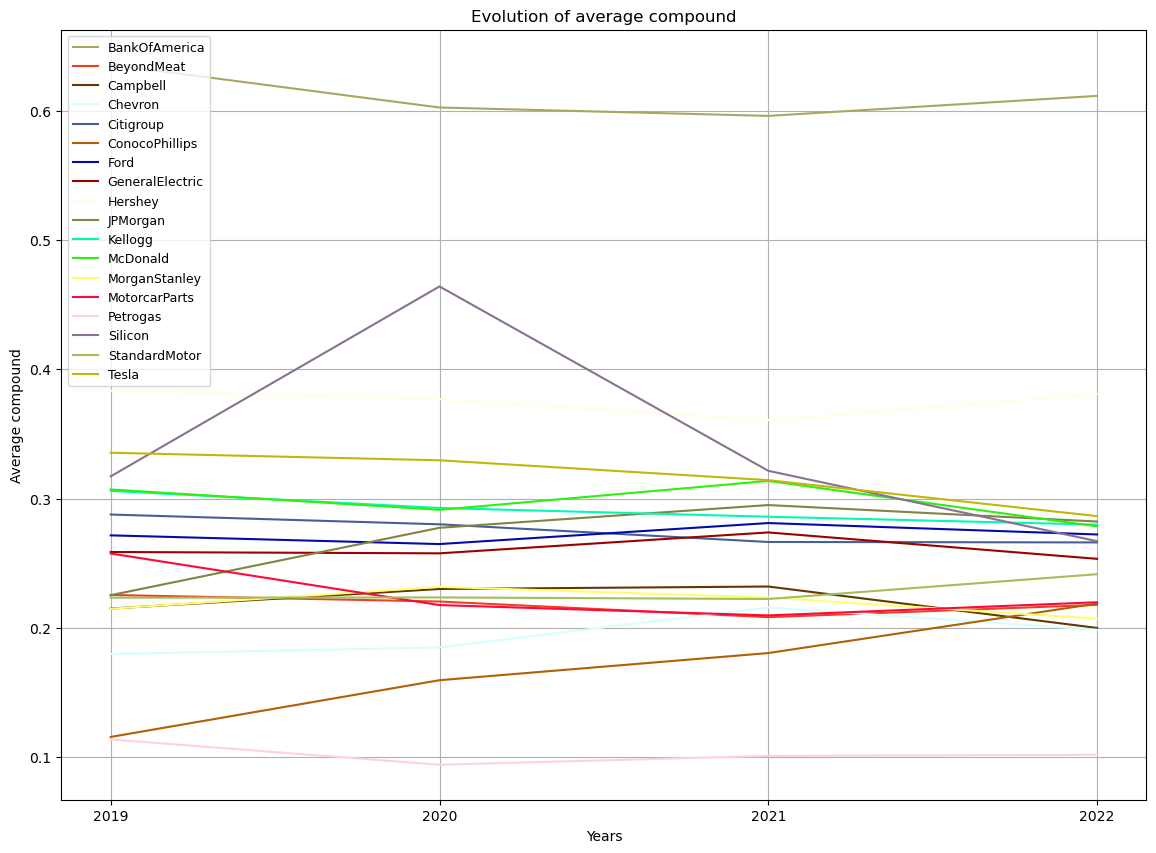

In [130]:
# Plot of the evolution of average compound 
# number of rows in df_phrases_evolution = 72
count = 0 
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(series[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=company_names[i])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Average compound')
    count += 1
plt.title('Evolution of average compound')
plt.grid()
plt.show

In [140]:
# plots evolution industry by industry 
df_phrases_evolution1 = df_phrases_evolution
df_phrases_evolution1 = df_phrases_evolution1.reset_index()
list_names = []
for name in df_phrases_evolution1['index']:
    list_names = list_names + [name[0:-4]] 
series = pd.Series(list_names, name = 'company name')
df = df_phrases_evolution1.merge(series,left_index=True, right_index=True)
df1 = df.copy()
cars_name = ['Ford', 'MotorcarParts', 'StandardMotor', 'Tesla']
banks_name = ['BankOfAmerica', 'Citigroup', 'JPMorgan', 'MorganStanley', 'Silicon' ]
energy_name = ['Chevron', 'ConocoPhillips', 'GeneralElectric', 'Petrogas']
food_name = ['BeyondMeat', 'Campbell', 'Hershey', 'Kellogg', 'McDonald']
count = 0 
df1['industry'] = 0
for i in range(72):
    if df1['company name'].loc[i] in cars_name: 
        df1['industry'].loc[i] = 'c'
    elif df1['company name'].loc[i] in banks_name: 
        df1['industry'].loc[i] = 'b'
    elif df1['company name'].loc[i] in energy_name: 
        df1['industry'].loc[i] = 'e'
    elif df1['company name'].loc[i] in food_name: 
        df1['industry'].loc[i] = 'f'
df_cars = df1[df1['industry'] == 'c'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 4
cars = df_cars.average_compound.set_axis(dates)
df_banks = df1[df1['industry'] == 'b'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 5
banks = df_banks.average_compound.set_axis(dates)
df_energy = df1[df1['industry'] == 'e'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 4
energy = df_energy.average_compound.set_axis(dates)
df_food = df1[df1['industry'] == 'f'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 5
food = df_food.average_compound.set_axis(dates)

<function matplotlib.pyplot.show(close=None, block=None)>

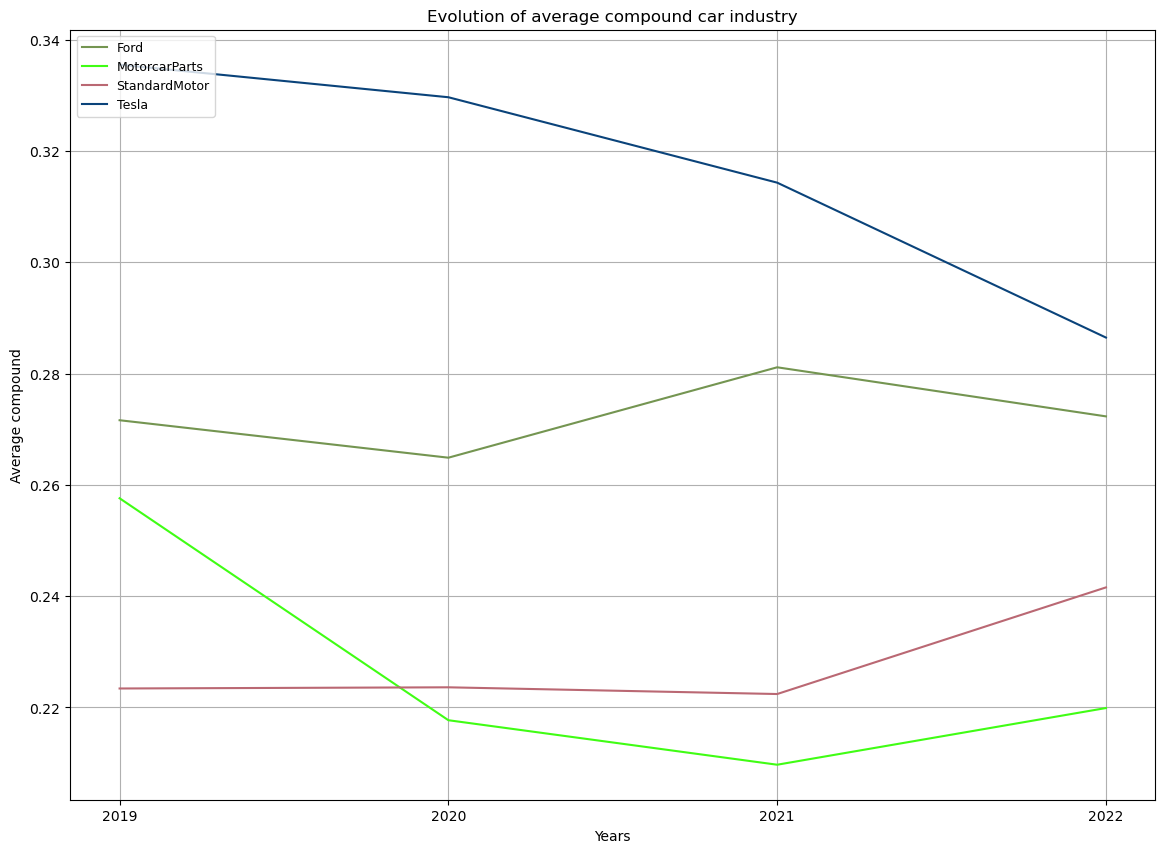

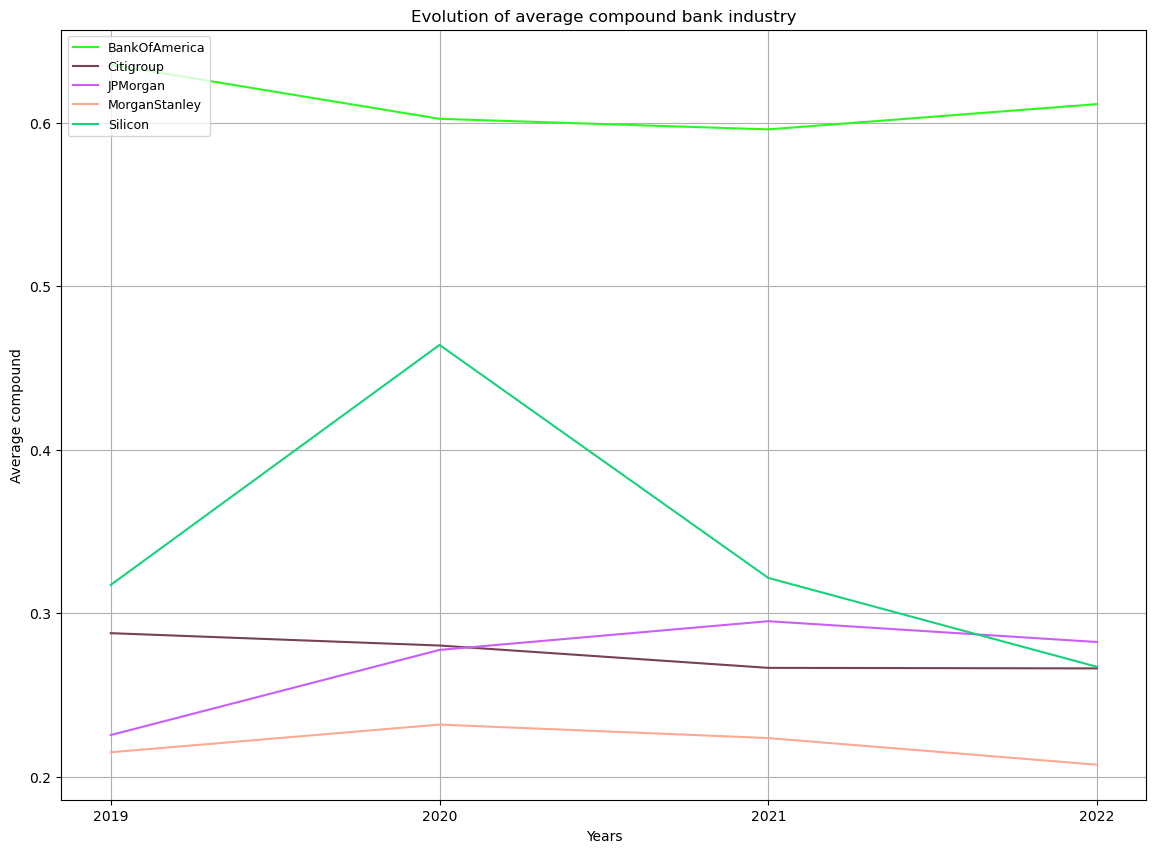

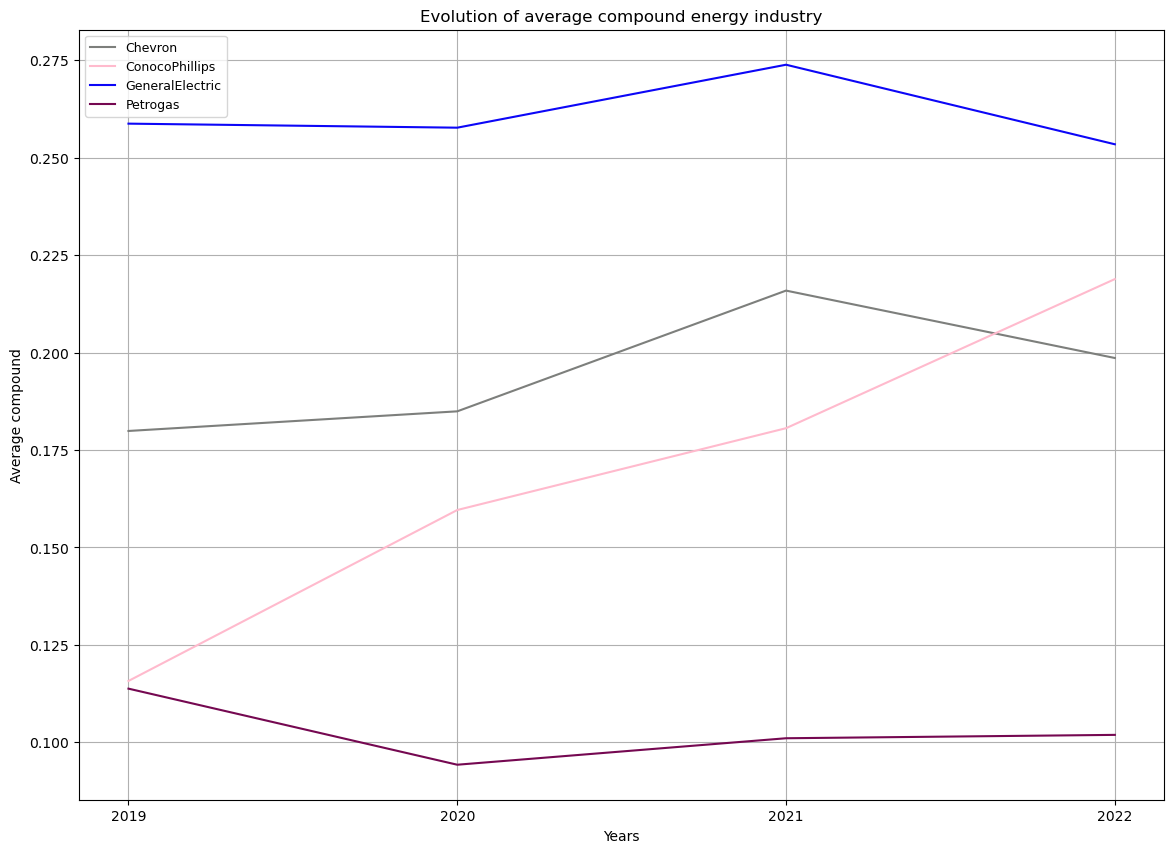

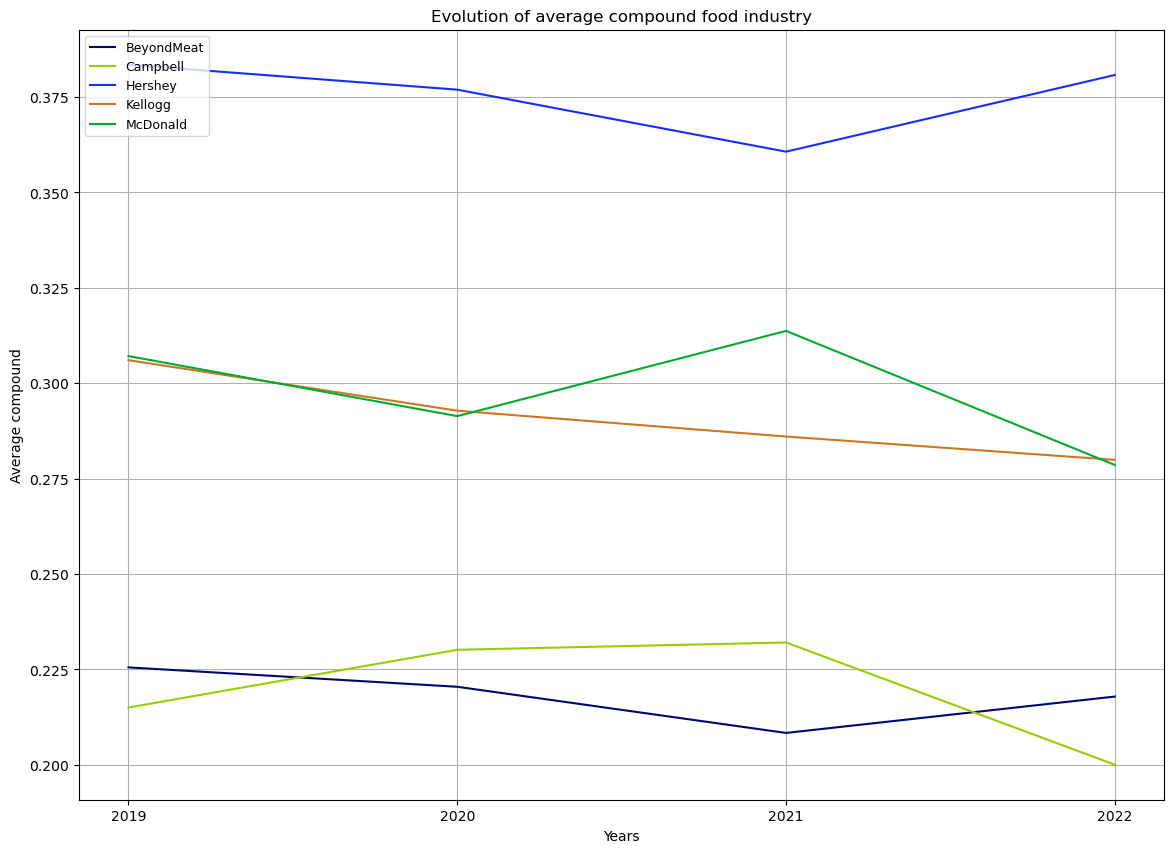

In [150]:
count = 0 
multiples_of_4 = multiples(4,4)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(cars[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=cars_name[count]) 
    # change company names  
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Average compound')
    count += 1
plt.title('Evolution of average compound car industry')
plt.grid()
plt.show

count = 0 
multiples_of_4 = multiples(4,5)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(banks[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=banks_name[count])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Average compound')
    count += 1
plt.title('Evolution of average compound bank industry')
plt.grid()
plt.show

count = 0 
multiples_of_4 = multiples(4,4)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(energy[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=energy_name[count])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Average compound')
    count += 1
plt.title('Evolution of average compound energy industry')
plt.grid()
plt.show

count = 0 
multiples_of_4 = multiples(4,5)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(food[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=food_name[count])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Average compound')
    count += 1
plt.title('Evolution of average compound food industry')
plt.grid()
plt.show

In [151]:
# some statistics of the evolution of the average compound score
mean_series = df_phrases_evolution.average_compound.set_axis(company_names)
dataframe = df_phrases_evolution.average_compound.set_axis(company_names).reset_index()
dataframe['mean'] = dataframe.groupby('index')['average_compound'].transform(lambda x: x.mean())
dataframe['std'] = dataframe.groupby('index')['average_compound'].transform(lambda x: x.std())
dataframe['change_19-22 (%)'] = dataframe.groupby('index')['average_compound'].transform(lambda x: ((x.iloc[-1]-x.iloc[0])/x.iloc[0])*100)
companies_mean_evolution = dataframe['mean'].unique()
companies_std_evolution = dataframe['std'].unique()
companies_change_evolution = dataframe['change_19-22 (%)'].unique()
statistics_dataframe = pd.DataFrame({'mean':companies_mean_evolution, 'std':companies_std_evolution, 'change_19-22 (%)': companies_change_evolution},index=dataframe['index'].unique())

In [152]:
# table with mean, standard deviation and percentage change of the average compound score over 2019-2022 company by company  
statistics_dataframe

,mean,std,change_19-22 (%)
BankOfAmerica,0.611379,0.017329,-3.792951
BeyondMeat,0.218057,0.007206,-3.389160
Campbell,0.219309,0.014947,-6.970298
Chevron,0.194844,0.016124,10.407639
Citigroup,0.275143,0.010628,-7.493704
ConocoPhillips,0.168711,0.042994,89.093007
Ford,0.272493,0.006667,0.255264
GeneralElectric,0.260958,0.008914,-2.045985
Hershey,0.375465,0.010214,-0.701594
JPMorgan,0.270055,0.030697,25.264505


The company that increases more its score is ConocoPhillips; for most of the company there is a negative trend, but Chevron, 
Ford, JPMorgan and StandardMotor had a positive change 

In [154]:
# visualization of some statistics
cars = ['Ford', 'Tesla', 'StandardMotor', 'MotorcarParts']
banks = ['MorganStanley', 'Silicon', 'JPMorgan', 'Citigroup', 'BankOfAmerica']
energy = ['Chevron', 'ConocoPhillips', 'GeneralElectric', 'Petrogas']
food = ['BeyondMeat', 'Campbell', 'Hershey', 'Kellogg', 'McDonald']
change = statistics_dataframe['change_19-22 (%)'].reset_index()
# computation for the average change in the compound score industry by industry 
cars_change = 0 
banks_change = 0 
energy_change = 0 
food_change = 0 
for i in range(18):
    if cars[0] == change['index'][i] or cars[1] == change['index'][i] or cars[2] == change['index'][i] or cars[3] == change['index'][i]:
        cars_change = cars_change + change['change_19-22 (%)'][i]
    elif banks[0] == change['index'][i] or banks[1] == change['index'][i] or banks[2] == change['index'][i] or banks[3] == change['index'][i] or banks[4] == change['index'][i]:
        banks_change = banks_change + change['change_19-22 (%)'][i]
    elif energy[0] == change['index'][i] or energy[1] == change['index'][i] or energy[2] == change['index'][i] or energy[3] == change['index'][i]:
        energy_change = energy_change + change['change_19-22 (%)'][i]
    elif food[0] == change['index'][i] or food[1] == change['index'][i] or food[2] == change['index'][i] or food[3] == change['index'][i] or food[4] == change['index'][i]:
        food_change = food_change + change['change_19-22 (%)'][i]
cars_average_change = cars_change/4
banks_average_change = banks_change/5
energy_average_change = energy_change/4
food_average_change = food_change/5

In [156]:
print(tabulate([['cars_average_change', cars_average_change],['banks_average_change',banks_average_change],
                ['energy_average_change',energy_average_change], ['food_average_change',food_average_change]],
                headers=['Statistics', 'Values(%)'],tablefmt = 'fancy_grid',stralign = 'center', numalign= 'center',floatfmt=".2f"))

╒═══════════════════════╤═════════════╕
│      Statistics       │  Values(%)  │
╞═══════════════════════╪═════════════╡
│  cars_average_change  │    -5.22    │
├───────────────────────┼─────────────┤
│ banks_average_change  │    -1.07    │
├───────────────────────┼─────────────┤
│ energy_average_change │    21.76    │
├───────────────────────┼─────────────┤
│  food_average_change  │    -5.78    │
╘═══════════════════════╧═════════════╛


Per industry, the biggest average change is in the energy sector due to ConocoPhillips

In [26]:
Evolution = pd.read_excel('sentiment_evolution19_22VADER.xlsx')
pd.set_option('display.max_rows',100)
Evolution1 = Evolution.drop(Evolution.index[56:64])
Evolution1 = Evolution1.reset_index()

In [27]:
Evolution1

,level_0,index,average_compound,perc_pos,perc_neg,perc_neut,mean_pos,mean_neg,mean_neut,perc_esg_phrases,Unnamed: 9,max compound,0.635571186440678,BankOfAmerica
0,0,BankOfAmerica2019,0.635571,0.881356,0.000000,0.118644,0.721129,0.000000,0.000000e+00,0.118236,NaN,min compound,0.094254,Petrogas
1,1,BankOfAmerica2020,0.602477,0.857143,0.000000,0.142857,0.702890,0.000000,0.000000e+00,0.121212,NaN,NaN,NaN,NaN
2,2,BankOfAmerica2021,0.596005,0.854545,0.000000,0.145455,0.697453,0.000000,0.000000e+00,0.126147,NaN,NaN,NaN,NaN
3,3,BankOfAmerica2022,0.611464,0.857143,0.000000,0.142857,0.713375,0.000000,0.000000e+00,0.129032,increasing,NaN,NaN,NaN
4,4,BeyondMeat2019,0.225533,0.607053,0.231738,0.161209,0.558902,-0.490700,-2.281250e-04,0.133986,NaN,NaN,NaN,NaN
5,5,BeyondMeat2020,0.220451,0.577236,0.227642,0.195122,0.583153,-0.509940,-4.208333e-04,0.138787,NaN,NaN,NaN,NaN
6,6,BeyondMeat2021,0.208354,0.579882,0.222880,0.197239,0.564672,-0.533504,-9.200000e-04,0.134626,NaN,NaN,NaN,NaN
7,7,BeyondMeat2022,0.217889,0.584582,0.229122,0.186296,0.572445,-0.508928,-7.816092e-04,0.125740,fluctuating,NaN,NaN,NaN
8,8,Campbell2019,0.215012,0.530000,0.202500,0.267500,0.532417,-0.332019,2.411215e-04,0.139276,NaN,NaN,NaN,NaN
9,9,Campbell2020,0.230146,0.521303,0.190476,0.288221,0.568300,-0.347763,4.486957e-04,0.141690,NaN,NaN,NaN,NaN


## POLARITY

This following cell was used to collect information of the average compound score to then store them in an excel file.

In [11]:
# ESG sentiment analysis using polarity approach for the last report posted by companies from 2019 to 2022 (except Royal Energy and Rivian) 
company_list_dir = os.getcwd() + '/10-K_time_2019-2022'
company_list_pdf = os.listdir(company_list_dir)
company_list_names = []
for company in company_list_pdf:
    company_list_names = company_list_names + [company[4:-4]] 
df_polarity = pd.DataFrame(columns=['polarity'], index=company_list_names)
count = 0  
for i in company_list_pdf: 
    x = extract(company_list_dir + f"/{i}")
    x = cleanhtml(x)
    x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)
    x = x.lower()
    x = remove_numbers(x)
    x = x.split(".")
    x,acceptance_rate = clean_list(x,words_list)
    x = ' '.join(x)
    polarity, list_negative, list_positive = count_neg_pos(x)
    df_polarity.loc[company_list_names[count]] = pd.Series({'polarity': polarity})
    count += 1

In [35]:
df_polarity

,index,polarity
0,BankOfAmerica2019,-0.636364
1,BankOfAmerica2020,-0.6
2,BankOfAmerica2021,-0.555556
3,BankOfAmerica2022,-0.555556
4,BeyondMeat2019,-0.30605
...,...,...
67,StandardMotor2022,-0.382263
68,Tesla2019,-0.399317
69,Tesla2020,-0.405204
70,Tesla2021,-0.447099


In [36]:
# visualization of the evolution over 2019-2022 of polarity 
multiples_of_4 = multiples(4,18)
dates = ['2019', '2020', '2021', '2022'] * 18
series = df_polarity.polarity.set_axis(dates)
company_names = []
for company in company_list_names:
    company_names = company_names + [company[0:-4]]
colors = list(mcolors.XKCD_COLORS.keys())

<function matplotlib.pyplot.show(close=None, block=None)>

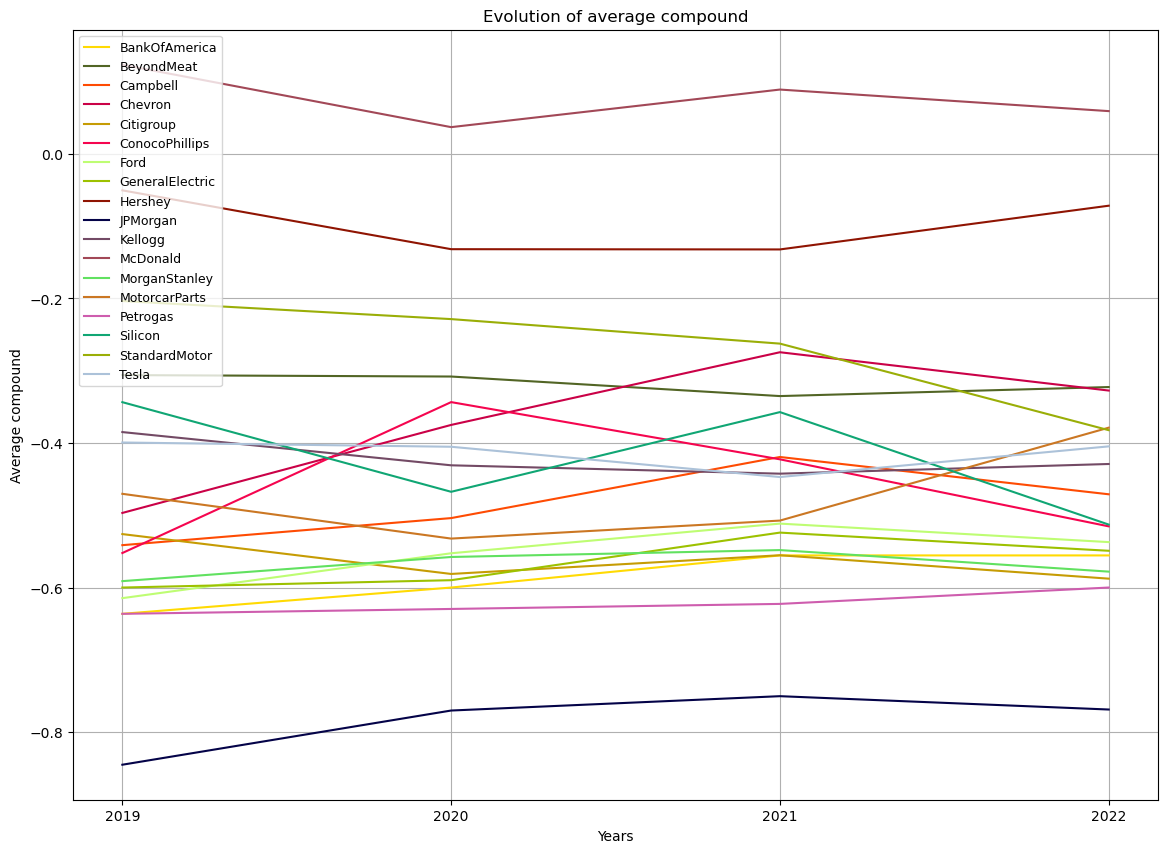

In [37]:
# Plot of the evolution of polarity
# # number of rows in df_phrases_evolution = 72
count = 0 
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(series[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=company_names[i])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Polarity')
    count += 1
plt.title('Evolution of polarity')
plt.grid()
plt.show

In [39]:
# plots evolution industry by industry 
list_names = []
for name in df_polarity['index']:
    list_names = list_names + [name[0:-4]] 
series = pd.Series(list_names, name = 'company name')
df = df_polarity.merge(series,left_index=True, right_index=True)
df1 = df.copy()
cars_name = ['Ford', 'MotorcarParts', 'StandardMotor', 'Tesla']
banks_name = ['BankOfAmerica', 'Citigroup', 'JPMorgan', 'MorganStanley', 'Silicon' ]
energy_name = ['Chevron', 'ConocoPhillips', 'GeneralElectric', 'Petrogas']
food_name = ['BeyondMeat', 'Campbell', 'Hershey', 'Kellogg', 'McDonald']
count = 0 
df1['industry'] = 0
for i in range(72):
    if df1['company name'].loc[i] in cars_name: 
        df1['industry'].loc[i] = 'c'
    elif df1['company name'].loc[i] in banks_name: 
        df1['industry'].loc[i] = 'b'
    elif df1['company name'].loc[i] in energy_name: 
        df1['industry'].loc[i] = 'e'
    elif df1['company name'].loc[i] in food_name: 
        df1['industry'].loc[i] = 'f'
df_cars = df1[df1['industry'] == 'c'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 4
cars = df_cars.polarity.set_axis(dates)
df_banks = df1[df1['industry'] == 'b'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 5
banks = df_banks.polarity.set_axis(dates)
df_energy = df1[df1['industry'] == 'e'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 4
energy = df_energy.polarity.set_axis(dates)
df_food = df1[df1['industry'] == 'f'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 5
food = df_food.polarity.set_axis(dates)

C:\Users\claca\AppData\Local\Temp\ipykernel_13520\2925451565.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['industry'].loc[i] = 'b'


<function matplotlib.pyplot.show(close=None, block=None)>

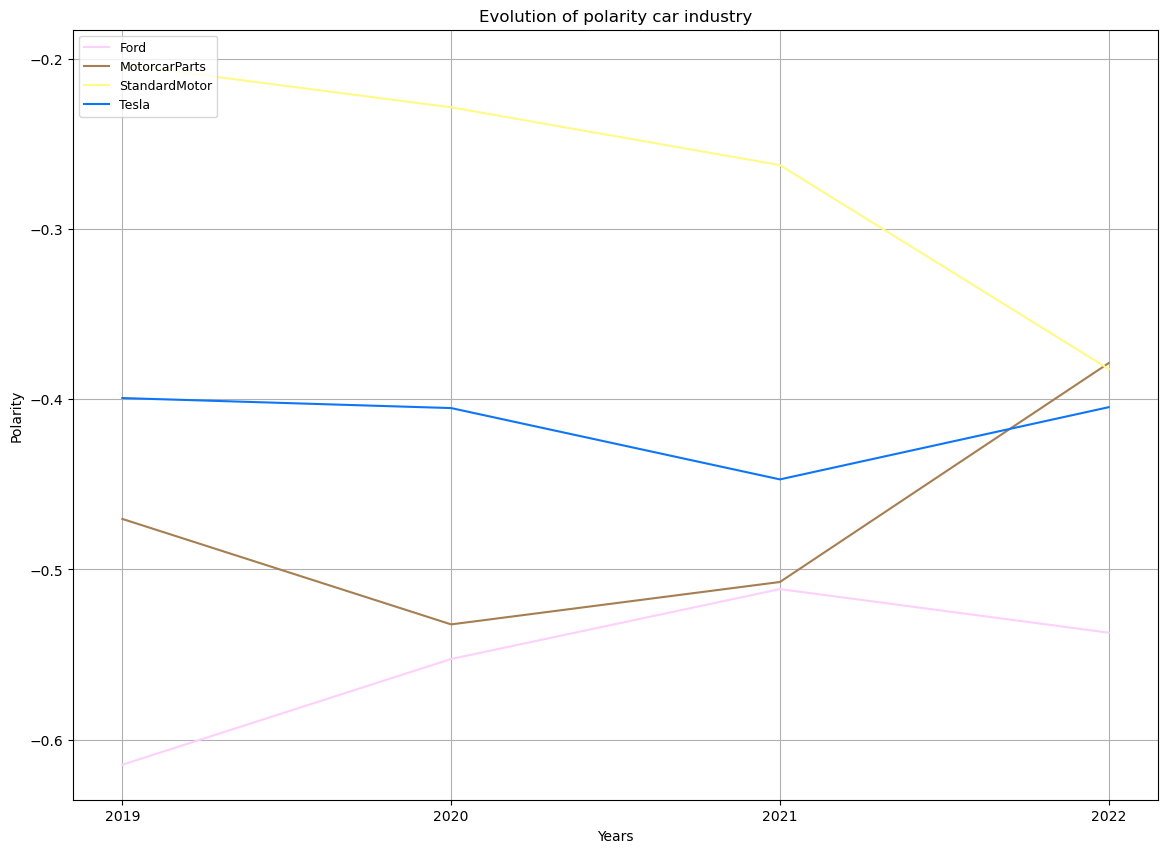

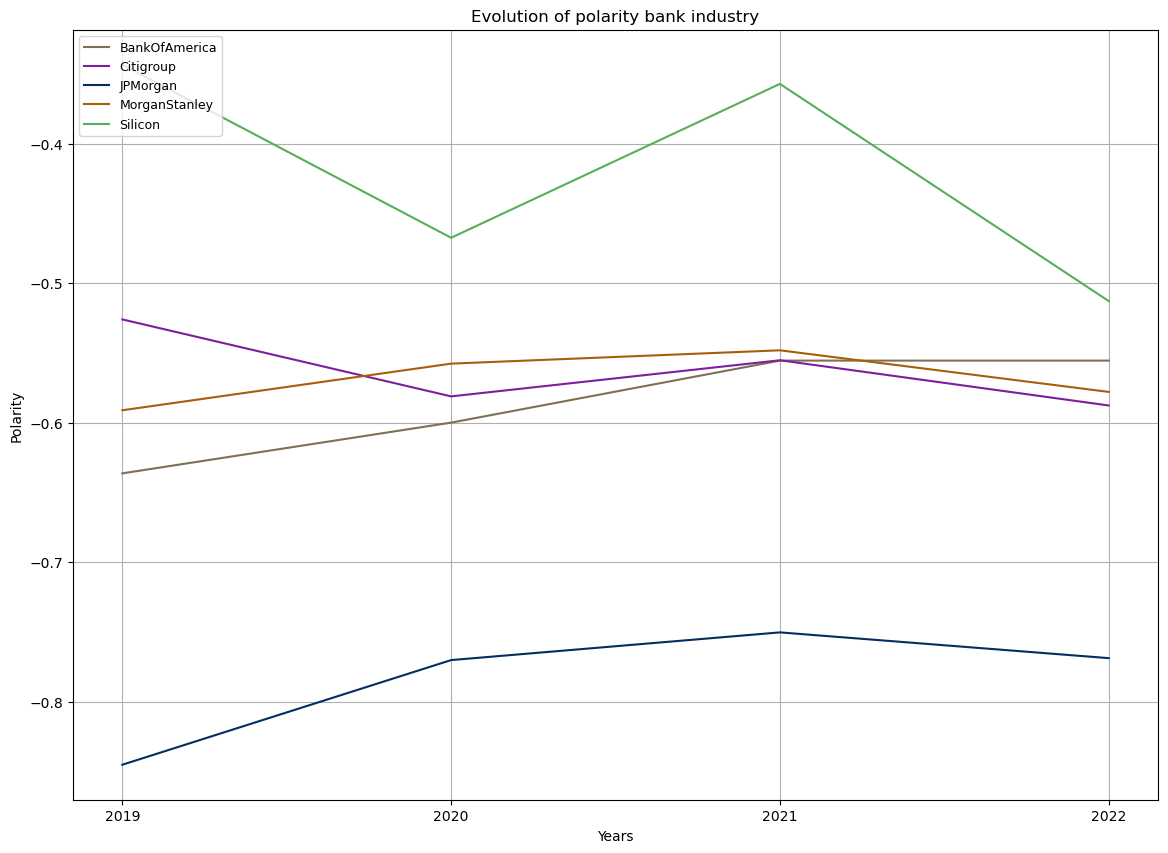

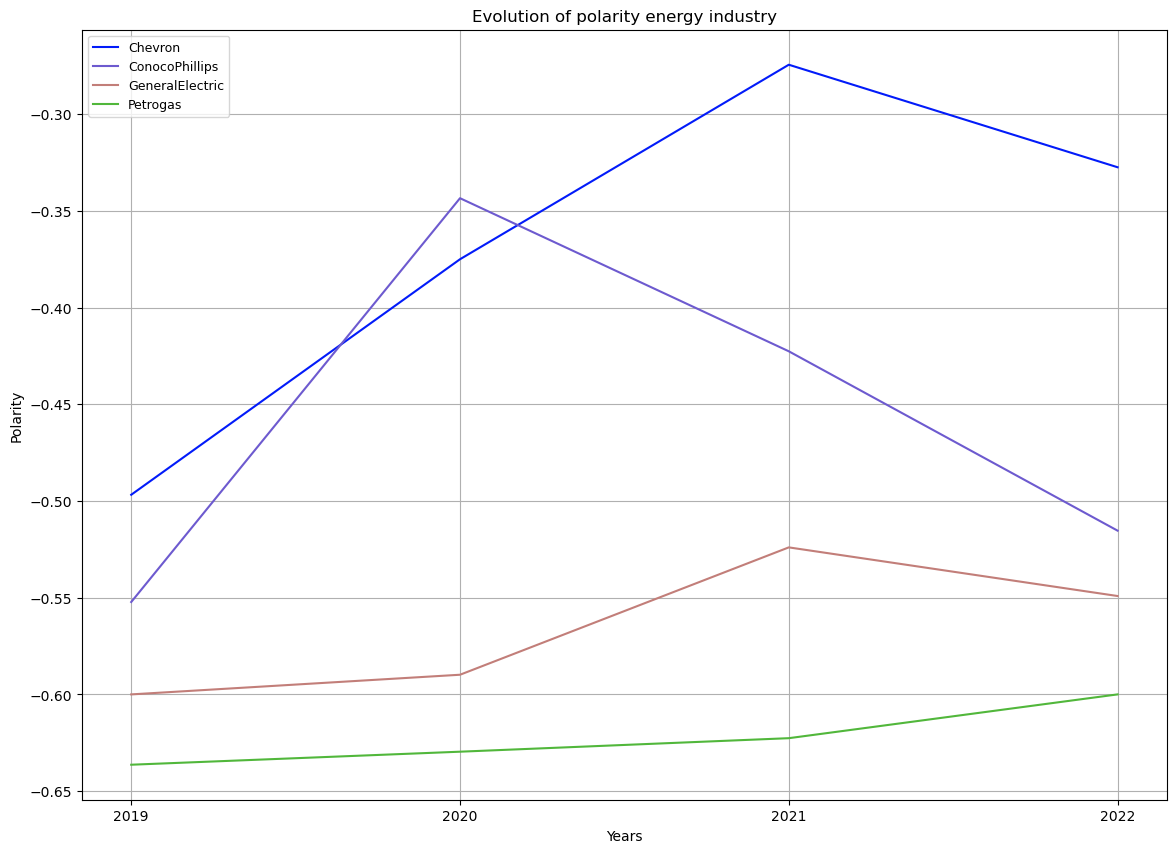

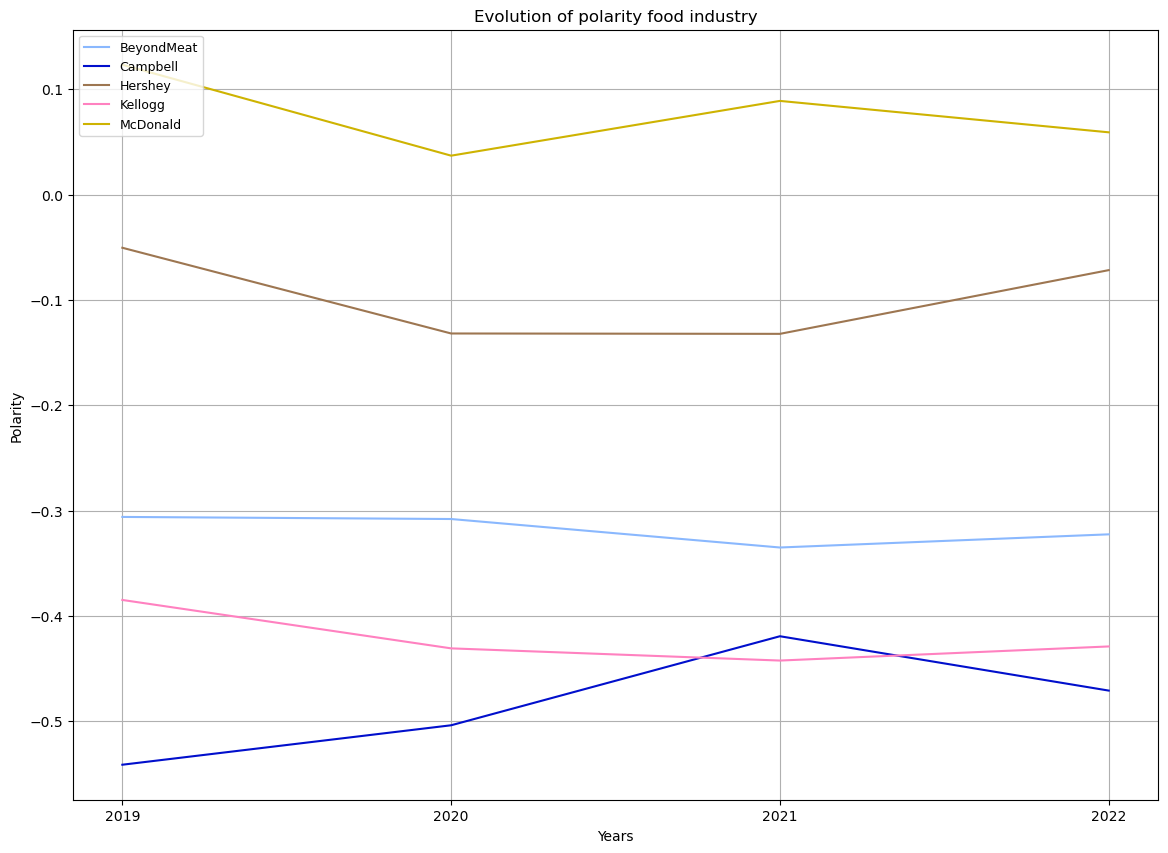

In [41]:
count = 0 
multiples_of_4 = multiples(4,4)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(cars[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=cars_name[count]) 
    # change company names  
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Polarity')
    count += 1
plt.title('Evolution of polarity car industry')
plt.grid()
plt.show

count = 0 
multiples_of_4 = multiples(4,5)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(banks[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=banks_name[count])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Polarity')
    count += 1
plt.title('Evolution of polarity bank industry')
plt.grid()
plt.show

count = 0 
multiples_of_4 = multiples(4,4)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(energy[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=energy_name[count])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Polarity')
    count += 1
plt.title('Evolution of polarity energy industry')
plt.grid()
plt.show

count = 0 
multiples_of_4 = multiples(4,5)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(food[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=food_name[count])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Polarity')
    count += 1
plt.title('Evolution of polarity food industry')
plt.grid()
plt.show

In [42]:
# some statistics about the evolution of polarity
mean_series = df_polarity.polarity.set_axis(company_names)
dataframe = df_polarity.polarity.set_axis(company_names).reset_index()
dataframe['mean'] = dataframe.groupby('index')['polarity'].transform(lambda x: x.mean())
dataframe['std'] = dataframe.groupby('index')['polarity'].transform(lambda x: x.std())
dataframe['change_19-22 (%)'] = dataframe.groupby('index')['polarity'].transform(lambda x: ((x.iloc[-1]-x.iloc[0])/x.iloc[0])*100)
companies_mean_evolution = dataframe['mean'].unique()
companies_std_evolution = dataframe['std'].unique()
companies_change_evolution = dataframe['change_19-22 (%)'].unique()
statistics_dataframe = pd.DataFrame({'mean':companies_mean_evolution, 'std':companies_std_evolution, 'change_19-22 (%)': companies_change_evolution},index=dataframe['index'].unique())

In [43]:
# table with mean, standard deviation and percentage change of polarity over 2019-2022 company by company  
statistics_dataframe

,mean,std,change_19-22 (%)
BankOfAmerica,-0.586869,0.039086,-12.698413
BeyondMeat,-0.317935,0.013600,5.401350
Campbell,-0.483900,0.051757,-13.004649
Chevron,-0.368407,0.094928,-34.088036
Citigroup,-0.562565,0.028083,11.723204
ConocoPhillips,-0.458401,0.094069,-6.682142
Ford,-0.553983,0.043861,-12.615678
GeneralElectric,-0.565739,0.035467,-8.477842
Hershey,-0.096527,0.041879,42.150171
JPMorgan,-0.783609,0.042020,-9.037649


In [44]:
# visualization of some statistics 
cars = ['Ford', 'Tesla', 'StandardMotor', 'MotorcarParts']
banks = ['MorganStanley', 'Silicon', 'JPMorgan', 'Citigroup', 'BankOfAmerica']
energy = ['Chevron', 'ConocoPhillips', 'GeneralElectric', 'Petrogas']
food = ['BeyondMeat', 'Campbell', 'Hershey', 'Kellogg', 'McDonald']
change = statistics_dataframe['change_19-22 (%)'].reset_index()
# computation for the average change in the compound score industry by industry 
cars_change = 0 
banks_change = 0 
energy_change = 0 
food_change = 0 
for i in range(18):
    if cars[0] == change['index'][i] or cars[1] == change['index'][i] or cars[2] == change['index'][i] or cars[3] == change['index'][i]:
        cars_change = cars_change + change['change_19-22 (%)'][i]
    elif banks[0] == change['index'][i] or banks[1] == change['index'][i] or banks[2] == change['index'][i] or banks[3] == change['index'][i] or banks[4] == change['index'][i]:
        banks_change = banks_change + change['change_19-22 (%)'][i]
    elif energy[0] == change['index'][i] or energy[1] == change['index'][i] or energy[2] == change['index'][i] or energy[3] == change['index'][i]:
        energy_change = energy_change + change['change_19-22 (%)'][i]
    elif food[0] == change['index'][i] or food[1] == change['index'][i] or food[2] == change['index'][i] or food[3] == change['index'][i] or food[4] == change['index'][i]:
        food_change = food_change + change['change_19-22 (%)'][i]
cars_average_change = cars_change/4
banks_average_change = banks_change/5
energy_average_change = energy_change/4
food_average_change = food_change/5

In [45]:
print(tabulate([['cars_average_change', cars_average_change],['banks_average_change',banks_average_change],
                ['energy_average_change',energy_average_change], ['food_average_change',food_average_change]],
                headers=['Statistics', 'Values(%)'],tablefmt = 'fancy_grid',stralign = 'center', numalign= 'center',floatfmt=".2f"))

╒═══════════════════════╤═════════════╕
│      Statistics       │  Values(%)  │
╞═══════════════════════╪═════════════╡
│  cars_average_change  │    14.27    │
├───────────────────────┼─────────────┤
│ banks_average_change  │    7.41     │
├───────────────────────┼─────────────┤
│ energy_average_change │   -13.74    │
├───────────────────────┼─────────────┤
│  food_average_change  │    -1.20    │
╘═══════════════════════╧═════════════╛


## BERT

In [4]:
# visualization analysis Bert's results
data = pd.read_csv('Sentimental_Bert_on_10K.csv')
data

,index,Bert score,perc_pos,perc_neg,perc_neut,perc_esg_phrases
0,BankOfAmerica2019,0.018182,0.018182,0.000000,0.981818,0.118236
1,BankOfAmerica2020,0.019231,0.019231,0.000000,0.980769,0.121212
2,BankOfAmerica2021,0.019231,0.019231,0.000000,0.980769,0.126147
3,BankOfAmerica2022,0.018868,0.018868,0.000000,0.981132,0.129032
4,BeyondMeat2019,0.010283,0.267352,0.257069,0.475578,0.133986
...,...,...,...,...,...,...
67,StandardMotor2022,-0.024814,0.133995,0.158809,0.707196,0.158033
68,Tesla2019,-0.052154,0.102041,0.154195,0.743764,0.111193
69,Tesla2020,-0.004525,0.131222,0.135747,0.733032,0.122608
70,Tesla2021,-0.013369,0.144385,0.157754,0.697861,0.117397


C:\Users\claca\AppData\Local\Temp\ipykernel_19288\960988710.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['industry'].loc[i] = 'b'


<function matplotlib.pyplot.show(close=None, block=None)>

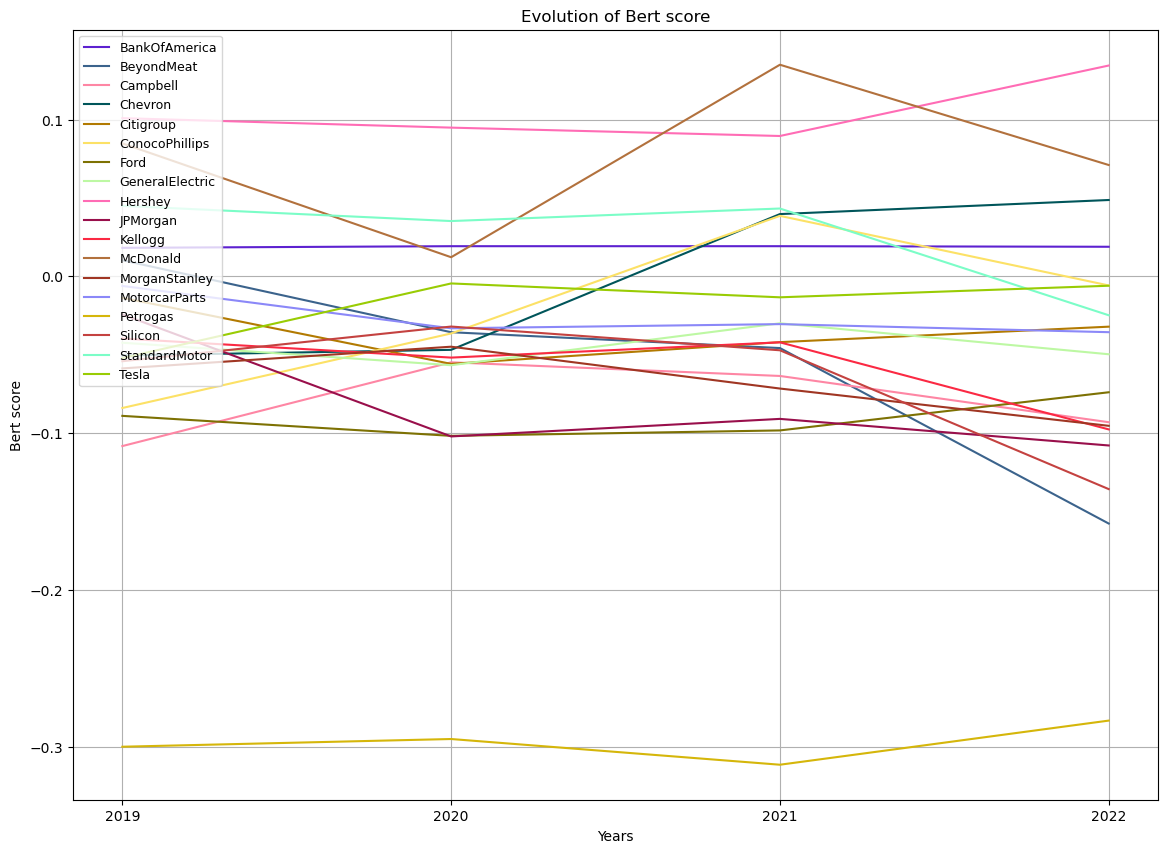

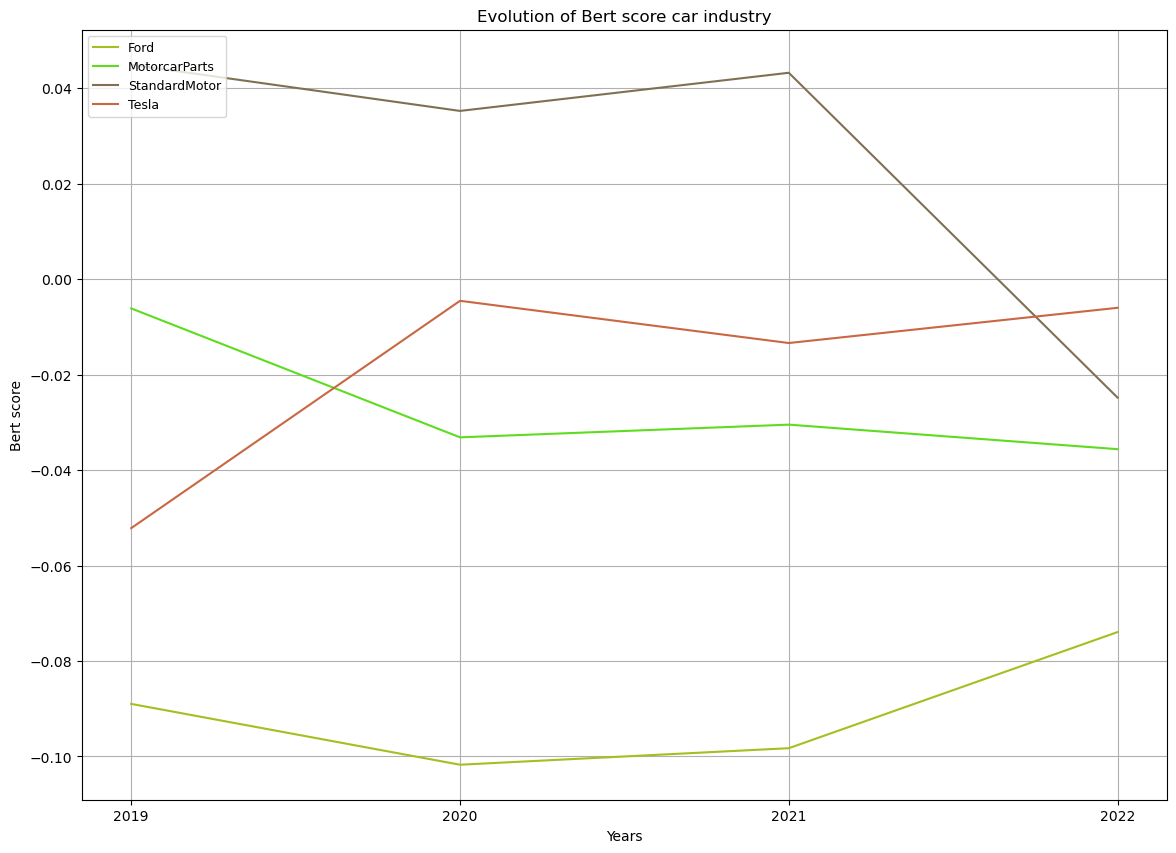

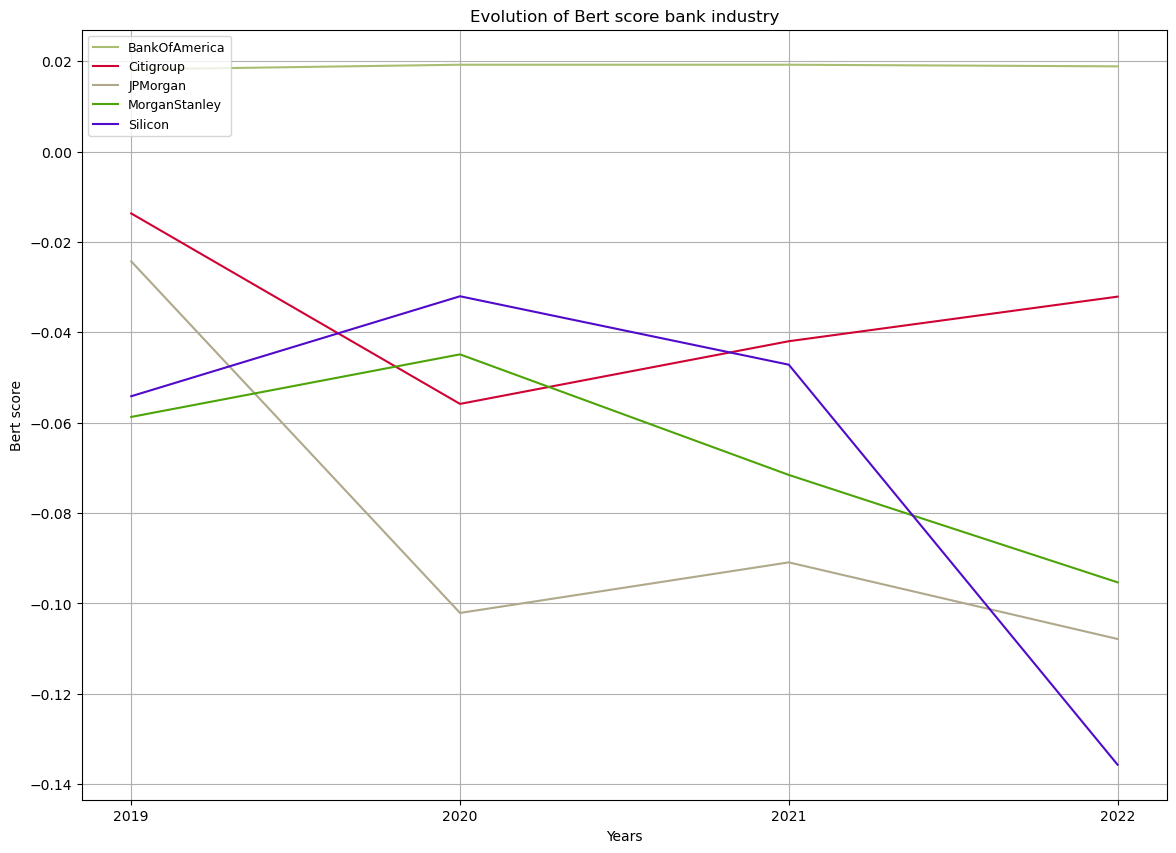

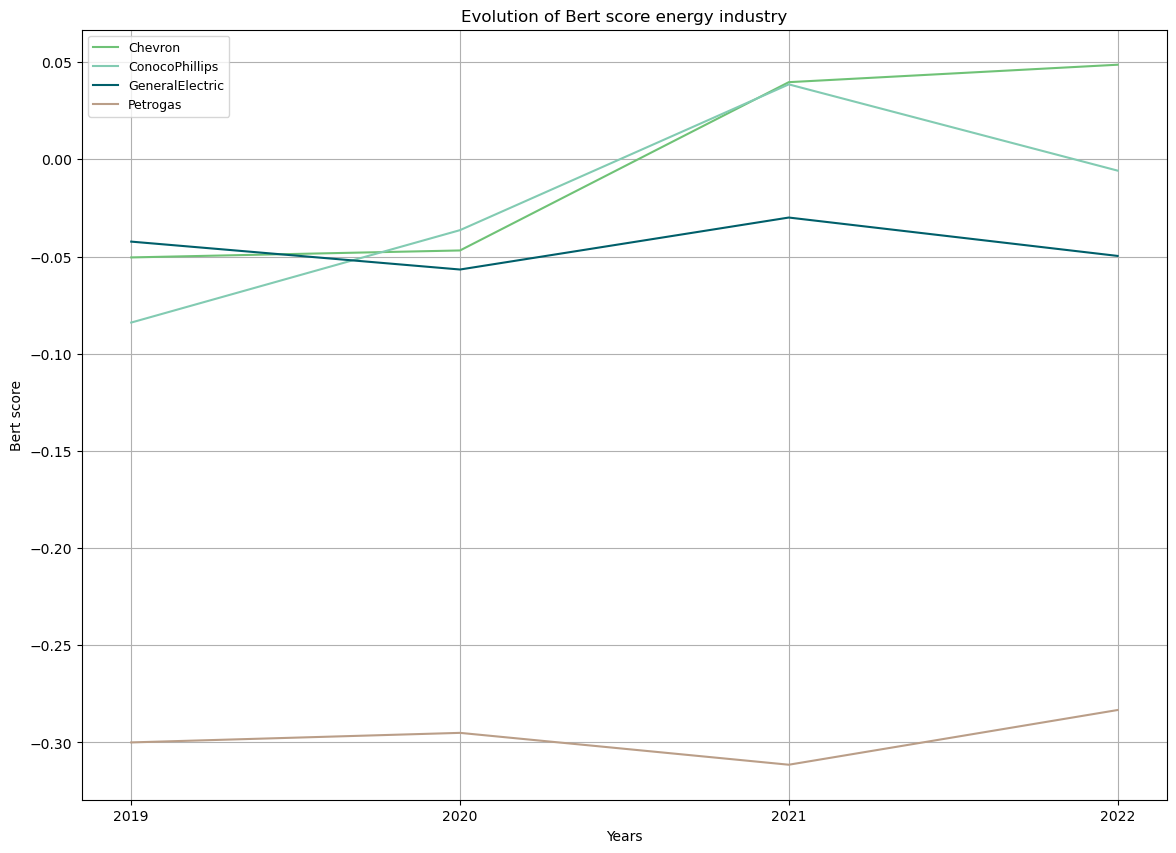

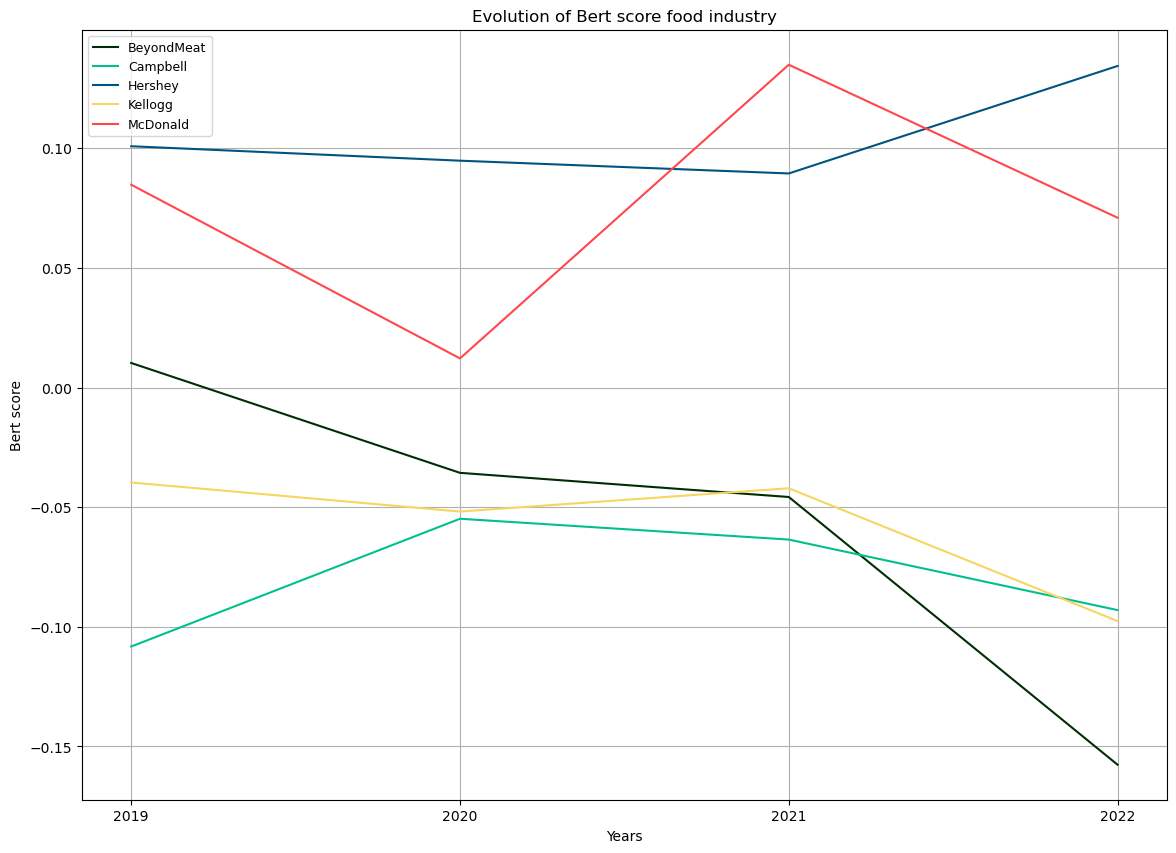

In [7]:
# visualization of the evolution of the Bert's score
company_list_dir = os.getcwd() + '/10-K_time_2019-2022'
company_list_pdf = os.listdir(company_list_dir)
company_list_names = []
for company in company_list_pdf:
    company_list_names = company_list_names + [company[4:-4]] 
multiples_of_4 = multiples(4,18)
dates = ['2019', '2020', '2021', '2022'] * 18
series = data['Bert score'].set_axis(dates)
company_names = []
for company in company_list_names:
    company_names = company_names + [company[0:-4]]
colors = list(mcolors.XKCD_COLORS.keys())
# Plot of the evolution of Bert's score 
# # number of rows in df_phrases_evolution = 72
count = 0 
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(series[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=company_names[i])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Bert score')
    count += 1
plt.title('Evolution of Bert score')
plt.grid()
plt.show

# plots evolution industry by industry 
list_names = []
for name in data['index']:
    list_names = list_names + [name[0:-4]] 
series = pd.Series(list_names, name = 'company name')
df = data.merge(series,left_index=True, right_index=True)
df1 = df.copy()
cars_name = ['Ford', 'MotorcarParts', 'StandardMotor', 'Tesla']
banks_name = ['BankOfAmerica', 'Citigroup', 'JPMorgan', 'MorganStanley', 'Silicon' ]
energy_name = ['Chevron', 'ConocoPhillips', 'GeneralElectric', 'Petrogas']
food_name = ['BeyondMeat', 'Campbell', 'Hershey', 'Kellogg', 'McDonald']
count = 0 
df1['industry'] = 0
for i in range(72):
    if df1['company name'].loc[i] in cars_name: 
        df1['industry'].loc[i] = 'c'
    elif df1['company name'].loc[i] in banks_name: 
        df1['industry'].loc[i] = 'b'
    elif df1['company name'].loc[i] in energy_name: 
        df1['industry'].loc[i] = 'e'
    elif df1['company name'].loc[i] in food_name: 
        df1['industry'].loc[i] = 'f'
df_cars = df1[df1['industry'] == 'c'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 4
cars = df_cars['Bert score'].set_axis(dates)
df_banks = df1[df1['industry'] == 'b'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 5
banks = df_banks['Bert score'].set_axis(dates)
df_energy = df1[df1['industry'] == 'e'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 4
energy = df_energy['Bert score'].set_axis(dates)
df_food = df1[df1['industry'] == 'f'].reset_index()
dates = ['2019', '2020', '2021', '2022'] * 5
food = df_food['Bert score'].set_axis(dates)

count = 0 
multiples_of_4 = multiples(4,4)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(cars[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=cars_name[count]) 
    # change company names  
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Bert score')
    count += 1
plt.title('Evolution of Bert score car industry')
plt.grid()
plt.show

count = 0 
multiples_of_4 = multiples(4,5)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(banks[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=banks_name[count])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Bert score')
    count += 1
plt.title('Evolution of Bert score bank industry')
plt.grid()
plt.show

count = 0 
multiples_of_4 = multiples(4,4)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(energy[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=energy_name[count])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Bert score')
    count += 1
plt.title('Evolution of Bert score energy industry')
plt.grid()
plt.show

count = 0 
multiples_of_4 = multiples(4,5)
plt.figure(figsize=(14, 10))
for i in multiples_of_4:
    plt.plot(food[i:i+4], c= mcolors.XKCD_COLORS[np.random.choice(colors)], label=food_name[count])
    plt.legend(loc=2, prop={'size': 9})
    plt.xlabel('Years')
    plt.ylabel('Bert score')
    count += 1
plt.title('Evolution of Bert score food industry')
plt.grid()
plt.show

In [53]:
# table with mean, standard deviation and percentage change of Bert's score over 2019-2022 company by company 
mean_series = data['Bert score'].set_axis(company_names)
dataframe = data['Bert score'].set_axis(company_names).reset_index()
dataframe['mean'] = dataframe.groupby('index')['Bert score'].transform(lambda x: x.mean())
dataframe['std'] = dataframe.groupby('index')['Bert score'].transform(lambda x: x.std())
dataframe['change_19-22 (%)'] = dataframe.groupby('index')['Bert score'].transform(lambda x: ((x.iloc[-1]-x.iloc[0])/abs(x.iloc[0]))*100)
companies_mean_evolution = dataframe['mean'].unique()
companies_std_evolution = dataframe['std'].unique()
companies_change_evolution = dataframe['change_19-22 (%)'].unique()
statistics_dataframe = pd.DataFrame({'mean':companies_mean_evolution, 'std':companies_std_evolution, 'change_19-22 (%)': companies_change_evolution},index=dataframe['index'].unique())
print(statistics_dataframe)

                     mean       std  change_19-22 (%)
BankOfAmerica    0.018878  0.000495          3.773585
BeyondMeat      -0.057188  0.071279      -1633.220721
Campbell        -0.079909  0.024980         14.064230
Chevron         -0.002233  0.053762        196.493020
Citigroup       -0.035895  0.017724       -134.594693
ConocoPhillips  -0.021904  0.051576         93.096179
Ford            -0.090727  0.012423         16.916806
GeneralElectric -0.044659  0.011429        -17.391304
Hershey          0.104927  0.020225         33.267425
JPMorgan        -0.081292  0.038647       -344.044944
Kellogg         -0.057796  0.027058       -146.078843
McDonald         0.075744  0.050500        -16.272189
MorganStanley   -0.067619  0.021447        -62.344945
MotorcarParts   -0.026332  0.013639       -482.195846
Petrogas        -0.297473  0.011663          5.555556
Silicon         -0.067251  0.046554       -150.633351
StandardMotor    0.024663  0.033254       -155.210918
Tesla           -0.019009  0

In [55]:
# some statistics about the evolution of Bert's score
mean_series = data['Bert score'].set_axis(company_names)
dataframe = data['Bert score'].set_axis(company_names).reset_index()
dataframe['mean'] = dataframe.groupby('index')['Bert score'].transform(lambda x: x.mean())
dataframe['std'] = dataframe.groupby('index')['Bert score'].transform(lambda x: x.std())
dataframe['change_19-22 (%)'] = dataframe.groupby('index')['Bert score'].transform(lambda x: ((x.iloc[-1]-x.iloc[0])/abs(x.iloc[0]))*100)
companies_mean_evolution = dataframe['mean'].unique()
companies_std_evolution = dataframe['std'].unique()
companies_change_evolution = dataframe['change_19-22 (%)'].unique()
statistics_dataframe = pd.DataFrame({'mean':companies_mean_evolution, 'std':companies_std_evolution, 'change_19-22 (%)': companies_change_evolution},index=dataframe['index'].unique())
print(statistics_dataframe)

cars = ['Ford', 'Tesla', 'StandardMotor', 'MotorcarParts']
banks = ['MorganStanley', 'Silicon', 'JPMorgan', 'Citigroup', 'BankOfAmerica']
energy = ['Chevron', 'ConocoPhillips', 'GeneralElectric', 'Petrogas']
food = ['BeyondMeat', 'Campbell', 'Hershey', 'Kellogg', 'McDonald']
change = statistics_dataframe['change_19-22 (%)'].reset_index()
# computation for the average change in the compound score industry by industry 
cars_change = 0 
banks_change = 0 
energy_change = 0 
food_change = 0 
for i in range(18):
    if cars[0] == change['index'][i] or cars[1] == change['index'][i] or cars[2] == change['index'][i] or cars[3] == change['index'][i]:
        cars_change = cars_change + change['change_19-22 (%)'][i]
    elif banks[0] == change['index'][i] or banks[1] == change['index'][i] or banks[2] == change['index'][i] or banks[3] == change['index'][i] or banks[4] == change['index'][i]:
        banks_change = banks_change + change['change_19-22 (%)'][i]
    elif energy[0] == change['index'][i] or energy[1] == change['index'][i] or energy[2] == change['index'][i] or energy[3] == change['index'][i]:
        energy_change = energy_change + change['change_19-22 (%)'][i]
    elif food[0] == change['index'][i] or food[1] == change['index'][i] or food[2] == change['index'][i] or food[3] == change['index'][i] or food[4] == change['index'][i]:
        food_change = food_change + change['change_19-22 (%)'][i]
cars_average_change = cars_change/4
banks_average_change = banks_change/5
energy_average_change = energy_change/4
food_average_change = food_change/5

                     mean       std  change_19-22 (%)
BankOfAmerica    0.018878  0.000495          3.773585
BeyondMeat      -0.057188  0.071279      -1633.220721
Campbell        -0.079909  0.024980         14.064230
Chevron         -0.002233  0.053762        196.493020
Citigroup       -0.035895  0.017724       -134.594693
ConocoPhillips  -0.021904  0.051576         93.096179
Ford            -0.090727  0.012423         16.916806
GeneralElectric -0.044659  0.011429        -17.391304
Hershey          0.104927  0.020225         33.267425
JPMorgan        -0.081292  0.038647       -344.044944
Kellogg         -0.057796  0.027058       -146.078843
McDonald         0.075744  0.050500        -16.272189
MorganStanley   -0.067619  0.021447        -62.344945
MotorcarParts   -0.026332  0.013639       -482.195846
Petrogas        -0.297473  0.011663          5.555556
Silicon         -0.067251  0.046554       -150.633351
StandardMotor    0.024663  0.033254       -155.210918
Tesla           -0.019009  0

In [57]:
print(tabulate([['cars_average_change', cars_average_change],['banks_average_change',banks_average_change],
                ['energy_average_change',energy_average_change], ['food_average_change',food_average_change]],
                headers=['Statistics', 'Values(%)'],tablefmt = 'fancy_grid',stralign = 'center', numalign= 'center',floatfmt=".2f"))

╒═══════════════════════╤═════════════╕
│      Statistics       │  Values(%)  │
╞═══════════════════════╪═════════════╡
│  cars_average_change  │   -132.99   │
├───────────────────────┼─────────────┤
│ banks_average_change  │   -137.57   │
├───────────────────────┼─────────────┤
│ energy_average_change │    69.44    │
├───────────────────────┼─────────────┤
│  food_average_change  │   -349.65   │
╘═══════════════════════╧═════════════╛


## POLARITY: CLOUDS OF WORDS

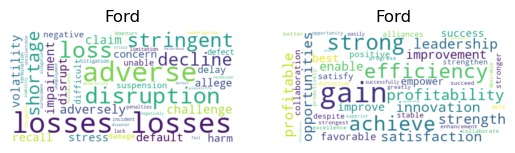

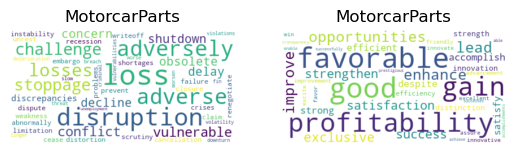

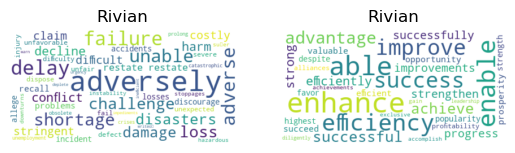

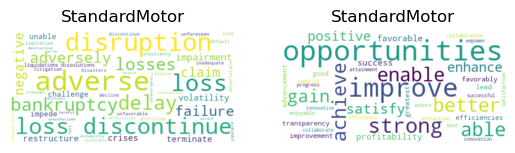

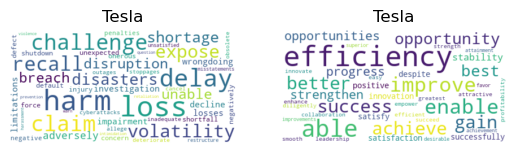

In [159]:
# Polarity with LM-dictionary 
company_list_dir = os.getcwd() + '/cars'
company_list_pdf = os.listdir(company_list_dir)
company_list_names = []
for company in company_list_pdf:
    company_list_names = company_list_names + [company[4:-8]] 
df_polarity = pd.DataFrame(columns=['polarity'], index=company_list_names)
count = 0  
for i in company_list_pdf: 
    x = extract(company_list_dir + f"/{i}")
    x = cleanhtml(x)
    x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)
    x = x.lower()
    x = remove_numbers(x)
    x = x.split(".")
    x,acceptance_rate = clean_list(x,words_list)
    x = ' '.join(x)
    polarity, list_negative, list_positive = count_neg_pos(x)
    df_polarity.loc[company_list_names[count]] = pd.Series({'polarity': polarity})
    name = company_list_names[count]
    list_negative = ' '.join(list_negative)
    list = lemmatize_word(list_negative)
    list = ' '.join(list)
    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(name)
    list_positive = ' '.join(list_positive)
    list = lemmatize_word(list_positive)
    list = ' '.join(list)
    plt.subplot(1,2,2)
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(name)
    plt.show()
    count += 1

In [160]:
df_polarity_cars = df_polarity

In [161]:
df_polarity_cars

,polarity
Ford,-0.537133
MotorcarParts,-0.378788
Rivian,-0.549296
StandardMotor,-0.382263
Tesla,-0.404682


In [163]:
mean_polarity_cars = df_polarity_cars.mean()
std_polarity_cars = df_polarity_cars.std()

The worst among cars: Rivian

The best among cars: MotorcarParts

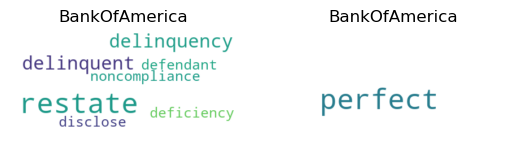

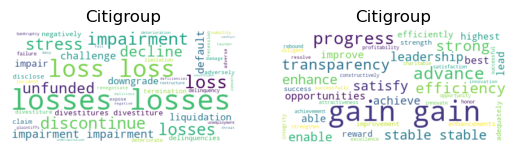

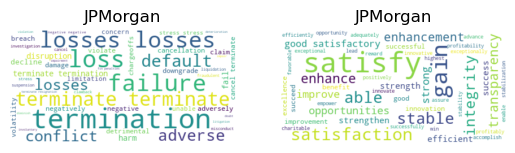

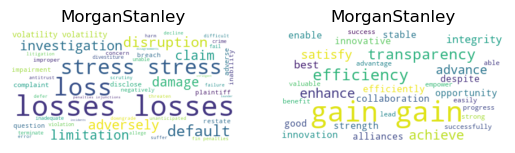

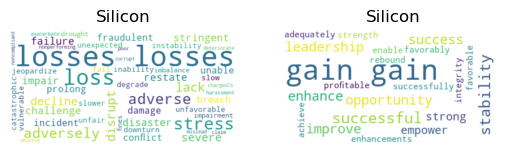

In [164]:
# Polarity with LM-dictionary 
company_list_dir = os.getcwd() + '/banks'
company_list_pdf = os.listdir(company_list_dir)
company_list_names = []
for company in company_list_pdf:
    company_list_names = company_list_names + [company[4:-8]] 
df_polarity = pd.DataFrame(columns=['polarity'], index=company_list_names)
count = 0 
for i in company_list_pdf: 
    x = extract(company_list_dir + f"/{i}")
    x = cleanhtml(x)
    x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)
    x = x.lower()
    x = remove_numbers(x)
    x = x.split(".")
    x,acceptance_rate = clean_list(x,words_list)
    x = ' '.join(x)
    polarity, list_negative, list_positive = count_neg_pos(x)
    df_polarity.loc[company_list_names[count]] = pd.Series({'polarity': polarity})
    name = company_list_names[count]
    list_negative = ' '.join(list_negative)
    list = lemmatize_word(list_negative)
    list = ' '.join(list)
    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(name)
    list_positive = ' '.join(list_positive)
    list = lemmatize_word(list_positive)
    list = ' '.join(list)
    plt.subplot(1,2,2)
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(name)
    plt.show()
    count += 1

In [166]:
df_polarity_banks = df_polarity 

In [170]:
mean_polarity_banks = df_polarity_banks.mean()
std_polarity_banks = df_polarity_banks.std()

The worst among banks: JPMorgan

The best among banks: Silicon

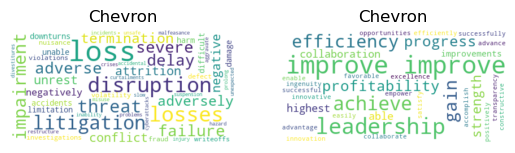

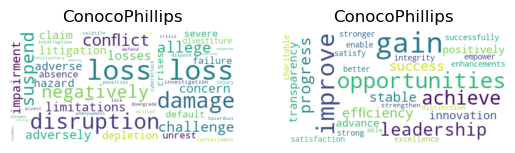

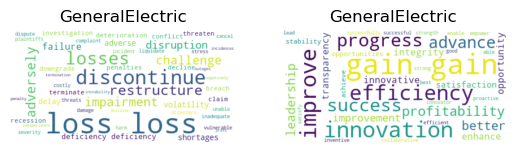

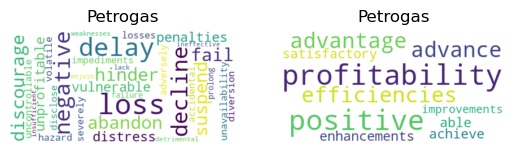

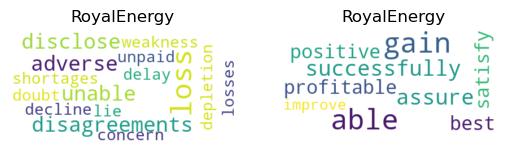

In [171]:
# Polarity with LM-dictionary 
company_list_dir = os.getcwd() + '/energy'
company_list_pdf = os.listdir(company_list_dir)
company_list_names = []
for company in company_list_pdf:
    company_list_names = company_list_names + [company[4:-8]] 
df_polarity = pd.DataFrame(columns=['polarity'], index=company_list_names)
count = 0 
for i in company_list_pdf: 
    x = extract(company_list_dir + f"/{i}")
    x = cleanhtml(x)
    x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)
    x = x.lower()
    x = remove_numbers(x)
    x = x.split(".")
    x,acceptance_rate = clean_list(x,words_list)
    x = ' '.join(x)
    polarity, list_negative, list_positive = count_neg_pos(x)
    df_polarity.loc[company_list_names[count]] = pd.Series({'polarity': polarity})
    name = company_list_names[count]
    list_negative = ' '.join(list_negative)
    list = lemmatize_word(list_negative)
    list = ' '.join(list)
    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(name)
    list_positive = ' '.join(list_positive)
    list = lemmatize_word(list_positive)
    list = ' '.join(list)
    plt.subplot(1,2,2)
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(name)
    plt.show()
    count += 1

In [172]:
df_polarity_energy = df_polarity 

In [173]:
df_polarity_energy

,polarity
Chevron,-0.327434
ConocoPhillips,-0.515337
GeneralElectric,-0.549133
Petrogas,-0.6
RoyalEnergy,-0.333333


In [175]:
mean_polarity_energy = df_polarity_energy.mean()
std_polarity_energy = df_polarity_energy.std()

The worst among energy: Petrogas

The best among enrgy: Chevron

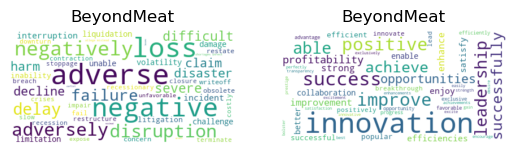

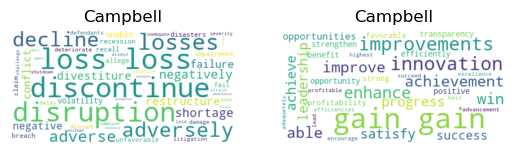

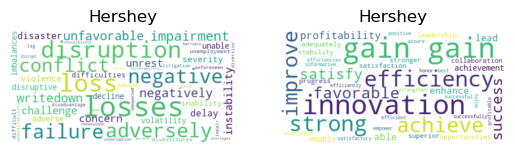

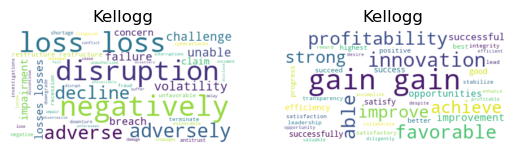

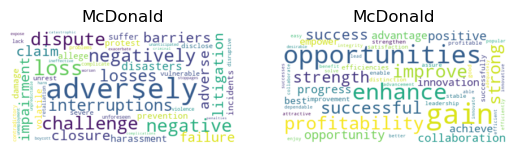

In [177]:
# Polarity with LM-dictionary 
company_list_dir = os.getcwd() + '/food'
company_list_pdf = os.listdir(company_list_dir)
company_list_names = []
for company in company_list_pdf:
    company_list_names = company_list_names + [company[4:-8]] 
df_polarity = pd.DataFrame(columns=['polarity'], index=company_list_names)
count = 0 
for i in company_list_pdf: 
    x = extract(company_list_dir + f"/{i}")
    x = cleanhtml(x)
    x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", x)
    x = x.lower()
    x = remove_numbers(x)
    x = x.split(".")
    x,acceptance_rate = clean_list(x,words_list)
    x = ' '.join(x)
    polarity, list_negative, list_positive = count_neg_pos(x)
    df_polarity.loc[company_list_names[count]] = pd.Series({'polarity': polarity})
    name = company_list_names[count]
    list_negative = ' '.join(list_negative)
    list = lemmatize_word(list_negative)
    list = ' '.join(list)
    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(name)
    list_positive = ' '.join(list_positive)
    list = lemmatize_word(list_positive)
    list = ' '.join(list)
    plt.subplot(1,2,2)
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(name)
    plt.show()
    count += 1

In [178]:
df_polarity_food = df_polarity 

In [179]:
df_polarity_food

,polarity
BeyondMeat,-0.322581
Campbell,-0.470968
Hershey,-0.071672
Kellogg,-0.429048
McDonald,0.059211


In [181]:
mean_polarity_food = df_polarity_food.mean()
std_polarity_food = df_polarity_food.std()

The worst among food: Campbell

The best among food: McDonald

In general, according to the LM dictionary the best company is McDonald while th worst is JPMorgan 

## Select sentences with Bert

Comparison of average compound score but only for Ford company for computational time reasons

In [148]:
ford = pd.read_csv('ford_selected_esg.csv')

In [149]:
ford1 = ford.copy()

In [150]:
list = []
for sentences in ford1['sentence']:
    a = cleanhtml(sentences)
    a = remove_numbers(a)
    a = remove_punctuation(a)
    a = remove_whitespace(a)
    list = list + [a]
data = vader_phrase(list)

In [155]:
# average compound ford 2022 selection with Bert 
data[0] 

0.22850233100233094

In [ ]:
# 0.272317 = average compound ford 2022 vader selection senteces with dictionary approach 

For Ford, compound scores are different depending on the method used to select esg-related sentences; this difference is not too big anyway.